# Rice Crops Diseases Detection Using ResNet50 Model

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, optimizers

In [2]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset configuration
DATASET_PATH = '/content/drive/MyDrive/gambar padi'
CLASS_NAMES = ['berat', 'sedang', 'sehat-ringan']

Mounted at /content/drive


In [ ]:
import os

dataset_path = '/content/drive/MyDrive/gambar padi'

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}: {len(os.listdir(class_path))} gambar")

sehat-ringan: 205 gambar
sedang: 200 gambar
berat: 200 gambar


# Constants

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
num_classes = 3


### SPLIT RATIO

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Konfigurasi
original_dataset_dir = '/content/drive/MyDrive/gambar padi'
CLASS_NAMES = ['berat', 'sedang', 'sehat-ringan']

# Rasio split yang ingin digunakan
split_ratios = [0.7, 0.8, 0.9]

for split_ratio in split_ratios:
    train_percent = round(split_ratio * 100)
    val_percent = round((1 - split_ratio) * 100)
    print(f"\n📦 Memproses rasio {train_percent}:{val_percent}")

    # Path direktori baru
    base_dir = f'/content/split_dataset_{train_percent}'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    # Hapus folder lama jika ada
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)

    # Buat struktur folder
    for folder in [train_dir, val_dir]:
        for class_name in CLASS_NAMES:
            os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Proses pembagian dan penyalinan file
    for class_name in CLASS_NAMES:
        class_path = os.path.join(original_dataset_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        # Split data
        train_imgs, val_imgs = train_test_split(images, train_size=split_ratio, random_state=42)

        # Salin ke train
        for img in train_imgs:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        # Salin ke val
        for img in val_imgs:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

    print(f"✅ Dataset berhasil dibagi dan disalin ke: {base_dir}")



📦 Memproses rasio 70:30
✅ Dataset berhasil dibagi dan disalin ke: /content/split_dataset_70

📦 Memproses rasio 80:20
✅ Dataset berhasil dibagi dan disalin ke: /content/split_dataset_80

📦 Memproses rasio 90:10
✅ Dataset berhasil dibagi dan disalin ke: /content/split_dataset_90


# Data Preparation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Ganti sesuai model yang Anda gunakan
import os

# Parameter umum
IMAGE_SIZE = 224
BATCH_SIZE = 32
CLASS_NAMES = ['berat', 'sedang', 'sehat-ringan']
split_ratios = [0.7, 0.8, 0.9]

for split_ratio in split_ratios:
    # Pembulatan untuk mencetak rasio dengan benar
    train_percent = round(split_ratio * 100)
    val_percent = round((1 - split_ratio) * 100)

    print(f"\n-- Memuat data untuk rasio {train_percent}:{val_percent} --")

    # Path direktori dataset hasil split
    base_dir = f'/content/split_dataset_{train_percent}'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    # Augmentasi untuk data training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Data validasi hanya preprocessing
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    # Generator untuk training
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    # Generator untuk validasi
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )



-- Memuat data untuk rasio 70:30 --
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.

-- Memuat data untuk rasio 80:20 --
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.

-- Memuat data untuk rasio 90:10 --
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


# Create a training data generator

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 544 images belonging to 3 classes.


# Create ResNet Model

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

num_classes = 3  # Jumlah kelas

def get_model():
    # Load base ResNet50 tanpa fully connected layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze sebagian besar layer
    for layer in base_model.layers:
        layer.trainable = False

    # Bangun model baru di atasnya
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)                    # ✅ Tambahkan dropout untuk regularisasi
    x = Dense(128, activation='relu')(x)  # ✅ Kurangi ukuran layer Dense agar tidak terlalu kompleks
    x = Dropout(0.5)(x)                    # ✅ Dropout kedua
    outputs = Dense(num_classes, activation='softmax', name='fcnew')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


# Compile Model

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 3  # Jumlah kelas

def get_model():
    # Base ResNet50 tanpa top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Bekukan semua layer awal (initial training phase)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)                    # Dropout untuk regularisasi
    x = Dense(128, activation='relu')(x)  # Dense layer
    x = Dropout(0.5)(x)                    # Dropout kedua
    outputs = Dense(num_classes, activation='softmax', name='fcnew')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Fungsi untuk compile model
def compile_model(lr=0.001):
    model = get_model()
    optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Train the Model


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import os

IMAGE_SIZE = 224
BATCH_SIZE = 32
num_classes = 3  # Jumlah kelas sesuai dataset Anda

# Fungsi membuat dan compile model
def compile_model(lr=0.001, l2_reg=1e-4):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    # Freeze base model
    for layer in base_model.layers:
        layer.trainable = False

    # Custom classifier with Dropout + L2 regularization
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax',
                   kernel_regularizer=regularizers.l2(l2_reg))(x)

    model = Model(inputs=base_model.input, outputs=output)

    optimizer = optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Fungsi training model
def train_model(split_ratio, lr, epochs, l2_reg=1e-4):
    split_percent = round(split_ratio * 100)
    base_dir = f'/content/split_dataset_{split_percent}'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    train_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ).flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    model = compile_model(lr=lr, l2_reg=l2_reg)
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=2
    )

    model_name = f'model_split{split_percent}_lr{lr}_ep{epochs}_l2{l2_reg}.h5'
    model.save(model_name)
    print(f"✅ Model berhasil disimpan: {model_name}")

    return model, history


### split ratio 0.7 Learning rate 0.001


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )



📦 Training model dengan split_ratio=70%, learning_rate=0.001, epochs=50
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/14 - 167s - 12s/step - accuracy: 0.3877 - loss: 1.8157 - val_accuracy: 0.5220 - val_loss: 1.0039
Epoch 2/50
14/14 - 165s - 12s/step - accuracy: 0.4326 - loss: 1.4238 - val_accuracy: 0.5385 - val_loss: 0.9928
Epoch 3/50
14/14 - 188s - 13s/step - accuracy: 0.4421 - loss: 1.2638 - val_accuracy: 0.5440 - val_loss: 0.9374
Epoch 4/50
14/14 - 149s - 11s/step - accuracy: 0.4823 - loss: 1.0956 - val_accuracy: 0.5275 - val_loss: 0.9380
Epoch 5/50
14/14 - 149s - 11s/step - accuracy: 0.5035 - loss: 1.0468 - val_accuracy: 0.5330 - val_loss: 0.9229
Epoch 6/50
14/14 - 152s - 11s/step - accuracy: 0.5059 - loss: 1.0099 - val_accuracy: 0.5769 - val_loss: 0.9208
Epoch 7/50
14/14 - 235s - 17s/step - accuracy: 0.5225 - loss: 0.9903 - val_accuracy: 0.6099 - val_loss: 0.9064
Epoch 8/50
14/14 - 185s - 13s/step - accuracy: 0.5366 - loss: 1.0160 - val_accuracy: 0.5824 - val_loss: 0.9125
Epoch 9/50
14/14 - 148s - 11s/step - accuracy: 0.5461 - loss: 0.9721 - val_accuracy: 0.5989 - val_loss: 0.9069
E

✅ Model berhasil disimpan: model_split70_lr0.001_ep50_l20.0001.h5


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )



📦 Training model dengan split_ratio=70%, learning_rate=0.001, epochs=100
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
Epoch 1/100
14/14 - 164s - 12s/step - accuracy: 0.3617 - loss: 1.8195 - val_accuracy: 0.4011 - val_loss: 1.0918
Epoch 2/100
14/14 - 146s - 10s/step - accuracy: 0.4184 - loss: 1.3486 - val_accuracy: 0.5110 - val_loss: 0.9913
Epoch 3/100
14/14 - 184s - 13s/step - accuracy: 0.4634 - loss: 1.1392 - val_accuracy: 0.5165 - val_loss: 0.9696
Epoch 4/100
14/14 - 184s - 13s/step - accuracy: 0.4704 - loss: 1.1252 - val_accuracy: 0.5879 - val_loss: 0.9351
Epoch 5/100
14/14 - 146s - 10s/step - accuracy: 0.5177 - loss: 1.0005 - val_accuracy: 0.5879 - val_loss: 0.9411
Epoch 6/100
14/14 - 147s - 11s/step - accuracy: 0.5012 - loss: 1.0118 - val_accuracy: 0.5989 - val_loss: 0.9345
Epoch 7/100
14/14 - 202s - 14s/step - accuracy: 0.5556 - loss: 0.9578 - val_accuracy: 0.6264 - val_loss: 0.9326
Epoch 8/100
14/14 - 143s - 10s/step - accuracy: 0.5556 - los

✅ Model berhasil disimpan: model_split70_lr0.001_ep100_l20.0001.h5


In [10]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )



📦 Training model dengan split_ratio=70%, learning_rate=0.001, epochs=200
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
14/14 - 162s - 12s/step - accuracy: 0.3948 - loss: 1.8561 - val_accuracy: 0.4451 - val_loss: 1.1629
Epoch 2/200
14/14 - 232s - 17s/step - accuracy: 0.3948 - loss: 1.5327 - val_accuracy: 0.5000 - val_loss: 0.9732
Epoch 3/200
14/14 - 145s - 10s/step - accuracy: 0.4941 - loss: 1.1727 - val_accuracy: 0.5824 - val_loss: 0.9556
Epoch 4/200
14/14 - 201s - 14s/step - accuracy: 0.5083 - loss: 1.0550 - val_accuracy: 0.5110 - val_loss: 0.9765
Epoch 5/200
14/14 - 206s - 15s/step - accuracy: 0.5532 - loss: 1.0217 - val_accuracy: 0.5000 - val_loss: 0.9774
Epoch 6/200
14/14 - 201s - 14s/step - accuracy: 0.5130 - loss: 1.0126 - val_accuracy: 0.5385 - val_loss: 0.9761
Epoch 7/200
14/14 - 203s - 14s/step - accuracy: 0.5248 - loss: 0.9651 - val_accuracy: 0.5220 - val_loss: 0.9663
Epoch 8/200
14/14 - 143s - 10s/step - accuracy: 0.5910 - loss: 0.9159 - val_accuracy: 0.5385 - val_loss: 0.9426
Epoch 9/200
14/14 - 211s - 15s/step - accuracy: 0.5579 - loss: 0.9104 - val_accuracy: 0.5549 - val_loss:

✅ Model berhasil disimpan: model_split70_lr0.001_ep200_l20.0001.h5


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [300]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )



📦 Training model dengan split_ratio=70%, learning_rate=0.001, epochs=300
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
14/14 - 168s - 12s/step - accuracy: 0.3239 - loss: 1.8704 - val_accuracy: 0.4505 - val_loss: 1.0731
Epoch 2/300
14/14 - 232s - 17s/step - accuracy: 0.4350 - loss: 1.3225 - val_accuracy: 0.4945 - val_loss: 1.0078
Epoch 3/300
14/14 - 148s - 11s/step - accuracy: 0.4492 - loss: 1.1942 - val_accuracy: 0.5330 - val_loss: 0.9848
Epoch 4/300
14/14 - 151s - 11s/step - accuracy: 0.4823 - loss: 1.0962 - val_accuracy: 0.5495 - val_loss: 0.9753
Epoch 5/300
14/14 - 186s - 13s/step - accuracy: 0.5177 - loss: 0.9767 - val_accuracy: 0.5769 - val_loss: 0.9609
Epoch 6/300
14/14 - 148s - 11s/step - accuracy: 0.5248 - loss: 1.0201 - val_accuracy: 0.5659 - val_loss: 0.9493
Epoch 7/300
14/14 - 148s - 11s/step - accuracy: 0.5863 - loss: 0.9891 - val_accuracy: 0.5989 - val_loss: 0.9360
Epoch 8/300
14/14 - 148s - 11s/step - accuracy: 0.5839 - loss: 0.9600 - val_accuracy: 0.5769 - val_loss: 0.9265
Epoch 9/300
14/14 - 185s - 13s/step - accuracy: 0.5697 - loss: 0.9436 - val_accuracy: 0.6099 - val_loss:

### split ratio 0.7 Learning rate 0.0001


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=70%, learning_rate=0.0001, epochs=50
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/14 - 78s - 6s/step - accuracy: 0.3262 - loss: 2.2561 - val_accuracy: 0.3297 - val_loss: 1.2654
Epoch 2/50
14/14 - 48s - 3s/step - accuracy: 0.3522 - loss: 1.9954 - val_accuracy: 0.3626 - val_loss: 1.1818
Epoch 3/50
14/14 - 40s - 3s/step - accuracy: 0.3688 - loss: 1.8762 - val_accuracy: 0.4066 - val_loss: 1.1348
Epoch 4/50
14/14 - 40s - 3s/step - accuracy: 0.3475 - loss: 1.7872 - val_accuracy: 0.4505 - val_loss: 1.1024
Epoch 5/50
14/14 - 40s - 3s/step - accuracy: 0.3830 - loss: 1.6268 - val_accuracy: 0.4560 - val_loss: 1.0798
Epoch 6/50
14/14 - 41s - 3s/step - accuracy: 0.3735 - loss: 1.4813 - val_accuracy: 0.4780 - val_loss: 1.0582
Epoch 7/50
14/14 - 39s - 3s/step - accuracy: 0.3617 - loss: 1.5977 - val_accuracy: 0.4780 - val_loss: 1.0407
Epoch 8/50
14/14 - 39s - 3s/step - accuracy: 0.4208 - loss: 1.4279 - val_accuracy: 0.4780 - val_loss: 1.0330
Epoch 9/50
14/14 - 39s - 3s/step - accuracy: 0.3901 - loss: 1.4270 - val_accuracy: 0.4945 - val_loss: 1.0103
Epoch 10/50
14/14 -

✅ Model berhasil disimpan: model_split70_lr0.0001_ep50_l20.0001.h5


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=70%, learning_rate=0.0001, epochs=100
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
14/14 - 76s - 5s/step - accuracy: 0.2861 - loss: 2.0562 - val_accuracy: 0.3791 - val_loss: 1.3503
Epoch 2/100
14/14 - 40s - 3s/step - accuracy: 0.3617 - loss: 1.8019 - val_accuracy: 0.3352 - val_loss: 1.2022
Epoch 3/100
14/14 - 39s - 3s/step - accuracy: 0.3475 - loss: 1.6957 - val_accuracy: 0.3846 - val_loss: 1.1584
Epoch 4/100
14/14 - 39s - 3s/step - accuracy: 0.3215 - loss: 1.6964 - val_accuracy: 0.3571 - val_loss: 1.1355
Epoch 5/100
14/14 - 37s - 3s/step - accuracy: 0.3499 - loss: 1.5530 - val_accuracy: 0.3846 - val_loss: 1.1087
Epoch 6/100
14/14 - 42s - 3s/step - accuracy: 0.3972 - loss: 1.5224 - val_accuracy: 0.4286 - val_loss: 1.0905
Epoch 7/100
14/14 - 40s - 3s/step - accuracy: 0.3924 - loss: 1.4114 - val_accuracy: 0.4066 - val_loss: 1.0793
Epoch 8/100
14/14 - 39s - 3s/step - accuracy: 0.3924 - loss: 1.4300 - val_accuracy: 0.4396 - val_loss: 1.0707
Epoch 9/100
14/14 - 47s - 3s/step - accuracy: 0.4492 - loss: 1.3044 - val_accuracy: 0.4396 - val_loss: 1.0630
Epoch 10/1

✅ Model berhasil disimpan: model_split70_lr0.0001_ep100_l20.0001.h5


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=70%, learning_rate=0.0001, epochs=200
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
14/14 - 171s - 12s/step - accuracy: 0.3404 - loss: 2.4378 - val_accuracy: 0.3516 - val_loss: 1.3224
Epoch 2/200
14/14 - 159s - 11s/step - accuracy: 0.3522 - loss: 1.8417 - val_accuracy: 0.3791 - val_loss: 1.1697
Epoch 3/200
14/14 - 153s - 11s/step - accuracy: 0.3735 - loss: 1.7831 - val_accuracy: 0.4231 - val_loss: 1.1117
Epoch 4/200
14/14 - 154s - 11s/step - accuracy: 0.3499 - loss: 1.6683 - val_accuracy: 0.4451 - val_loss: 1.0724
Epoch 5/200
14/14 - 156s - 11s/step - accuracy: 0.4184 - loss: 1.5324 - val_accuracy: 0.4780 - val_loss: 1.0425
Epoch 6/200
14/14 - 160s - 11s/step - accuracy: 0.3688 - loss: 1.5294 - val_accuracy: 0.5055 - val_loss: 1.0269
Epoch 7/200
14/14 - 152s - 11s/step - accuracy: 0.4255 - loss: 1.4647 - val_accuracy: 0.5110 - val_loss: 1.0220
Epoch 8/200
14/14 - 150s - 11s/step - accuracy: 0.4350 - loss: 1.3259 - val_accuracy: 0.5110 - val_loss: 1.0100
Epoch 9/200
14/14 - 150s - 11s/step - accuracy: 0.4303 - loss: 1.3666 - val_accuracy: 0.5275 - val_loss:

✅ Model berhasil disimpan: model_split70_lr0.0001_ep200_l20.0001.h5


In [ ]:
split_ratio = 0.7
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [300]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=70%, learning_rate=0.0001, epochs=300
Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
14/14 - 207s - 15s/step - accuracy: 0.3310 - loss: 1.9454 - val_accuracy: 0.3297 - val_loss: 1.2351
Epoch 2/300
14/14 - 154s - 11s/step - accuracy: 0.3357 - loss: 1.7637 - val_accuracy: 0.3901 - val_loss: 1.1685
Epoch 3/300
14/14 - 147s - 10s/step - accuracy: 0.3333 - loss: 1.6245 - val_accuracy: 0.4176 - val_loss: 1.1275
Epoch 4/300
14/14 - 185s - 13s/step - accuracy: 0.3995 - loss: 1.4229 - val_accuracy: 0.4615 - val_loss: 1.0810
Epoch 5/300
14/14 - 154s - 11s/step - accuracy: 0.3641 - loss: 1.5569 - val_accuracy: 0.4670 - val_loss: 1.0561
Epoch 6/300
14/14 - 193s - 14s/step - accuracy: 0.3735 - loss: 1.3800 - val_accuracy: 0.4615 - val_loss: 1.0419
Epoch 7/300
14/14 - 201s - 14s/step - accuracy: 0.4184 - loss: 1.3473 - val_accuracy: 0.4780 - val_loss: 1.0326
Epoch 8/300
14/14 - 137s - 10s/step - accuracy: 0.4350 - loss: 1.3768 - val_accuracy: 0.4615 - val_loss: 1.0226
Epoch 9/300
14/14 - 143s - 10s/step - accuracy: 0.4279 - loss: 1.2512 - val_accuracy: 0.4670 - val_loss:

###Split ratio 0.8 Learning rate 0.001

In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )




📦 Training model dengan split_ratio=80%, learning_rate=0.001, epochs=50
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 - 150s - 9s/step - accuracy: 0.3388 - loss: 1.7727 - val_accuracy: 0.4463 - val_loss: 1.0581
Epoch 2/50
16/16 - 140s - 9s/step - accuracy: 0.4380 - loss: 1.2958 - val_accuracy: 0.5620 - val_loss: 0.9374
Epoch 3/50
16/16 - 135s - 8s/step - accuracy: 0.4545 - loss: 1.1474 - val_accuracy: 0.6116 - val_loss: 0.9040
Epoch 4/50
16/16 - 134s - 8s/step - accuracy: 0.4752 - loss: 1.1263 - val_accuracy: 0.6198 - val_loss: 0.9011
Epoch 5/50
16/16 - 134s - 8s/step - accuracy: 0.5021 - loss: 1.0430 - val_accuracy: 0.6281 - val_loss: 0.8962
Epoch 6/50
16/16 - 137s - 9s/step - accuracy: 0.5248 - loss: 1.0171 - val_accuracy: 0.6281 - val_loss: 0.8989
Epoch 7/50
16/16 - 136s - 8s/step - accuracy: 0.5372 - loss: 0.9928 - val_accuracy: 0.5785 - val_loss: 0.8901
Epoch 8/50
16/16 - 133s - 8s/step - accuracy: 0.5331 - loss: 0.9739 - val_accuracy: 0.6612 - val_loss: 0.8654
Epoch 9/50
16/16 - 148s - 9s/step - accuracy: 0.5579 - loss: 0.9430 - val_accuracy: 0.6364 - val_loss: 0.8588
Epoch 10/5

✅ Model berhasil disimpan: model_split80_lr0.001_ep50_l20.0001.h5


In [ ]:
  split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )




📦 Training model dengan split_ratio=80%, learning_rate=0.001, epochs=100
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
Epoch 1/100
16/16 - 153s - 10s/step - accuracy: 0.3616 - loss: 1.7848 - val_accuracy: 0.4463 - val_loss: 1.0599
Epoch 2/100
16/16 - 135s - 8s/step - accuracy: 0.4649 - loss: 1.2651 - val_accuracy: 0.6033 - val_loss: 0.9432
Epoch 3/100
16/16 - 140s - 9s/step - accuracy: 0.4525 - loss: 1.2494 - val_accuracy: 0.5868 - val_loss: 0.9509
Epoch 4/100
16/16 - 148s - 9s/step - accuracy: 0.5165 - loss: 1.0506 - val_accuracy: 0.5868 - val_loss: 0.9422
Epoch 5/100
16/16 - 134s - 8s/step - accuracy: 0.4938 - loss: 1.0294 - val_accuracy: 0.6364 - val_loss: 0.9288
Epoch 6/100
16/16 - 149s - 9s/step - accuracy: 0.4897 - loss: 1.0023 - val_accuracy: 0.6446 - val_loss: 0.9098
Epoch 7/100
16/16 - 133s - 8s/step - accuracy: 0.5434 - loss: 0.9405 - val_accuracy: 0.6777 - val_loss: 0.9063
Epoch 8/100
16/16 - 133s - 8s/step - accuracy: 0.5145 - loss: 1.01

✅ Model berhasil disimpan: model_split80_lr0.001_ep100_l20.0001.h5


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=80%, learning_rate=0.001, epochs=200
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
16/16 - 179s - 11s/step - accuracy: 0.3905 - loss: 1.7546 - val_accuracy: 0.6281 - val_loss: 0.9463
Epoch 2/200
16/16 - 161s - 10s/step - accuracy: 0.3946 - loss: 1.3784 - val_accuracy: 0.6694 - val_loss: 0.8748
Epoch 3/200
16/16 - 151s - 9s/step - accuracy: 0.4979 - loss: 1.1549 - val_accuracy: 0.6364 - val_loss: 0.9012
Epoch 4/200
16/16 - 148s - 9s/step - accuracy: 0.4835 - loss: 1.0993 - val_accuracy: 0.6198 - val_loss: 0.9106
Epoch 5/200
16/16 - 160s - 10s/step - accuracy: 0.5062 - loss: 1.0530 - val_accuracy: 0.6364 - val_loss: 0.8916
Epoch 6/200
16/16 - 160s - 10s/step - accuracy: 0.4959 - loss: 1.0080 - val_accuracy: 0.6446 - val_loss: 0.8788
Epoch 7/200
16/16 - 150s - 9s/step - accuracy: 0.5496 - loss: 0.9829 - val_accuracy: 0.6529 - val_loss: 0.8653
Epoch 8/200
16/16 - 151s - 9s/step - accuracy: 0.5682 - loss: 0.9415 - val_accuracy: 0.6529 - val_loss: 0.8556
Epoch 9/200
16/16 - 155s - 10s/step - accuracy: 0.5103 - loss: 1.0248 - val_accuracy: 0.6777 - val_loss: 0.8

✅ Model berhasil disimpan: model_split80_lr0.001_ep200_l20.0001.h5


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [300]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )

### SPLIT RATIO 0.8 LEARNING RATE 0.0001


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=80%, learning_rate=0.0001, epochs=50
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 - 76s - 5s/step - accuracy: 0.3409 - loss: 1.9056 - val_accuracy: 0.4380 - val_loss: 1.1011
Epoch 2/50
16/16 - 45s - 3s/step - accuracy: 0.3884 - loss: 1.6626 - val_accuracy: 0.4380 - val_loss: 1.0704
Epoch 3/50
16/16 - 44s - 3s/step - accuracy: 0.3636 - loss: 1.6421 - val_accuracy: 0.4711 - val_loss: 1.0282
Epoch 4/50
16/16 - 43s - 3s/step - accuracy: 0.3864 - loss: 1.6306 - val_accuracy: 0.4876 - val_loss: 0.9702
Epoch 5/50
16/16 - 42s - 3s/step - accuracy: 0.3719 - loss: 1.5073 - val_accuracy: 0.5537 - val_loss: 0.9391
Epoch 6/50
16/16 - 43s - 3s/step - accuracy: 0.3884 - loss: 1.4538 - val_accuracy: 0.5950 - val_loss: 0.9234
Epoch 7/50
16/16 - 45s - 3s/step - accuracy: 0.3822 - loss: 1.4572 - val_accuracy: 0.6364 - val_loss: 0.9137
Epoch 8/50
16/16 - 43s - 3s/step - accuracy: 0.3926 - loss: 1.4311 - val_accuracy: 0.6446 - val_loss: 0.9071
Epoch 9/50
16/16 - 40s - 3s/step - accuracy: 0.4050 - loss: 1.3869 - val_accuracy: 0.6529 - val_loss: 0.9092
Epoch 10/50
16/16 -

✅ Model berhasil disimpan: model_split80_lr0.0001_ep50_l20.0001.h5


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=80%, learning_rate=0.0001, epochs=100
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
16/16 - 168s - 11s/step - accuracy: 0.3492 - loss: 2.1094 - val_accuracy: 0.3967 - val_loss: 1.1628
Epoch 2/100
16/16 - 157s - 10s/step - accuracy: 0.3802 - loss: 1.8801 - val_accuracy: 0.4793 - val_loss: 1.1095
Epoch 3/100
16/16 - 152s - 9s/step - accuracy: 0.3967 - loss: 1.7730 - val_accuracy: 0.4793 - val_loss: 1.0674
Epoch 4/100
16/16 - 151s - 9s/step - accuracy: 0.3740 - loss: 1.6903 - val_accuracy: 0.5124 - val_loss: 1.0330
Epoch 5/100
16/16 - 150s - 9s/step - accuracy: 0.3471 - loss: 1.6926 - val_accuracy: 0.5537 - val_loss: 0.9939
Epoch 6/100
16/16 - 208s - 13s/step - accuracy: 0.4194 - loss: 1.4897 - val_accuracy: 0.5372 - val_loss: 0.9779
Epoch 7/100
16/16 - 150s - 9s/step - accuracy: 0.4029 - loss: 1.4889 - val_accuracy: 0.5702 - val_loss: 0.9652
Epoch 8/100
16/16 - 150s - 9s/step - accuracy: 0.4463 - loss: 1.4132 - val_accuracy: 0.5455 - val_loss: 0.9581
Epoch 9/100
16/16 - 150s - 9s/step - accuracy: 0.3967 - loss: 1.5041 - val_accuracy: 0.5372 - val_loss: 0.956

✅ Model berhasil disimpan: model_split80_lr0.0001_ep100_l20.0001.h5


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=80%, learning_rate=0.0001, epochs=200
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
16/16 - 92s - 6s/step - accuracy: 0.2934 - loss: 1.9952 - val_accuracy: 0.3306 - val_loss: 1.1315
Epoch 2/200
16/16 - 82s - 5s/step - accuracy: 0.3347 - loss: 1.8883 - val_accuracy: 0.4132 - val_loss: 1.0596
Epoch 3/200
16/16 - 84s - 5s/step - accuracy: 0.3285 - loss: 1.7034 - val_accuracy: 0.4545 - val_loss: 1.0089
Epoch 4/200
16/16 - 84s - 5s/step - accuracy: 0.3616 - loss: 1.5372 - val_accuracy: 0.5124 - val_loss: 0.9816
Epoch 5/200
16/16 - 84s - 5s/step - accuracy: 0.3843 - loss: 1.5084 - val_accuracy: 0.5289 - val_loss: 0.9651
Epoch 6/200
16/16 - 87s - 5s/step - accuracy: 0.4174 - loss: 1.4989 - val_accuracy: 0.5207 - val_loss: 0.9610
Epoch 7/200
16/16 - 83s - 5s/step - accuracy: 0.4050 - loss: 1.4207 - val_accuracy: 0.5455 - val_loss: 0.9499
Epoch 8/200
16/16 - 83s - 5s/step - accuracy: 0.4153 - loss: 1.4007 - val_accuracy: 0.5455 - val_loss: 0.9431
Epoch 9/200
16/16 - 84s - 5s/step - accuracy: 0.4318 - loss: 1.3561 - val_accuracy: 0.5455 - val_loss: 0.9368
Epoch 10/2

✅ Model berhasil disimpan: model_split80_lr0.0001_ep200_l20.0001.h5


In [ ]:
split_ratio = 0.8
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [300]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=80%, learning_rate=0.0001, epochs=300
Found 484 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
16/16 - 158s - 10s/step - accuracy: 0.3037 - loss: 2.1703 - val_accuracy: 0.3388 - val_loss: 1.2415
Epoch 2/300
16/16 - 127s - 8s/step - accuracy: 0.3244 - loss: 2.0826 - val_accuracy: 0.3967 - val_loss: 1.1412
Epoch 3/300
16/16 - 128s - 8s/step - accuracy: 0.3616 - loss: 1.8405 - val_accuracy: 0.4876 - val_loss: 1.0696
Epoch 4/300
16/16 - 132s - 8s/step - accuracy: 0.3740 - loss: 1.6884 - val_accuracy: 0.5041 - val_loss: 1.0435
Epoch 5/300
16/16 - 129s - 8s/step - accuracy: 0.3595 - loss: 1.6801 - val_accuracy: 0.4876 - val_loss: 1.0221
Epoch 6/300
16/16 - 128s - 8s/step - accuracy: 0.4112 - loss: 1.5344 - val_accuracy: 0.5289 - val_loss: 1.0049
Epoch 7/300
16/16 - 143s - 9s/step - accuracy: 0.4050 - loss: 1.4734 - val_accuracy: 0.5455 - val_loss: 0.9960
Epoch 8/300
16/16 - 131s - 8s/step - accuracy: 0.4504 - loss: 1.3872 - val_accuracy: 0.5702 - val_loss: 0.9744
Epoch 9/300
16/16 - 129s - 8s/step - accuracy: 0.4793 - loss: 1.3708 - val_accuracy: 0.5950 - val_loss: 0.9398


### SPLIT RATIO 0.9 LR 0.001


In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.001, epochs=50
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 - 179s - 11s/step - accuracy: 0.3824 - loss: 1.7930 - val_accuracy: 0.4754 - val_loss: 1.3003
Epoch 2/50
17/17 - 159s - 9s/step - accuracy: 0.4890 - loss: 1.3321 - val_accuracy: 0.5246 - val_loss: 0.9882
Epoch 3/50
17/17 - 197s - 12s/step - accuracy: 0.4688 - loss: 1.2002 - val_accuracy: 0.5246 - val_loss: 0.9903
Epoch 4/50
17/17 - 156s - 9s/step - accuracy: 0.4761 - loss: 1.0818 - val_accuracy: 0.5738 - val_loss: 0.9975
Epoch 5/50
17/17 - 154s - 9s/step - accuracy: 0.5533 - loss: 0.9871 - val_accuracy: 0.5738 - val_loss: 0.9774
Epoch 6/50
17/17 - 161s - 9s/step - accuracy: 0.5699 - loss: 0.9811 - val_accuracy: 0.6393 - val_loss: 0.9487
Epoch 7/50
17/17 - 154s - 9s/step - accuracy: 0.5607 - loss: 0.9643 - val_accuracy: 0.5574 - val_loss: 0.9320
Epoch 8/50
17/17 - 156s - 9s/step - accuracy: 0.5570 - loss: 0.9570 - val_accuracy: 0.5738 - val_loss: 0.9231
Epoch 9/50
17/17 - 155s - 9s/step - accuracy: 0.5717 - loss: 0.9491 - val_accuracy: 0.5574 - val_loss: 0.9108
Epoch 10

✅ Model berhasil disimpan: model_split90_lr0.001_ep50_l20.0001.h5


In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.001, epochs=100
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 - 162s - 10s/step - accuracy: 0.3787 - loss: 2.0356 - val_accuracy: 0.4754 - val_loss: 1.0725
Epoch 2/100
17/17 - 147s - 9s/step - accuracy: 0.4779 - loss: 1.2587 - val_accuracy: 0.4590 - val_loss: 1.0073
Epoch 3/100
17/17 - 206s - 12s/step - accuracy: 0.4853 - loss: 1.1313 - val_accuracy: 0.5410 - val_loss: 0.9761
Epoch 4/100
17/17 - 148s - 9s/step - accuracy: 0.5037 - loss: 1.0333 - val_accuracy: 0.5246 - val_loss: 0.9573
Epoch 5/100
17/17 - 208s - 12s/step - accuracy: 0.5184 - loss: 1.0114 - val_accuracy: 0.5246 - val_loss: 0.9613
Epoch 6/100
17/17 - 161s - 9s/step - accuracy: 0.5404 - loss: 1.0086 - val_accuracy: 0.5738 - val_loss: 0.9573
Epoch 7/100
17/17 - 190s - 11s/step - accuracy: 0.5699 - loss: 0.9866 - val_accuracy: 0.5902 - val_loss: 0.9381
Epoch 8/100
17/17 - 148s - 9s/step - accuracy: 0.5533 - loss: 0.9385 - val_accuracy: 0.6721 - val_loss: 0.9176
Epoch 9/100
17/17 - 151s - 9s/step - accuracy: 0.5349 - loss: 0.9765 - val_accuracy: 0.5410 - val_loss: 0.91

✅ Model berhasil disimpan: model_split90_lr0.001_ep100_l20.0001.h5


In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.001, epochs=200
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
17/17 - 156s - 9s/step - accuracy: 0.3566 - loss: 1.7369 - val_accuracy: 0.4754 - val_loss: 1.0545
Epoch 2/200
17/17 - 135s - 8s/step - accuracy: 0.4210 - loss: 1.3255 - val_accuracy: 0.4754 - val_loss: 1.0302
Epoch 3/200
17/17 - 147s - 9s/step - accuracy: 0.4926 - loss: 1.1165 - val_accuracy: 0.5574 - val_loss: 0.9647
Epoch 4/200
17/17 - 141s - 8s/step - accuracy: 0.4853 - loss: 1.0824 - val_accuracy: 0.5574 - val_loss: 0.9628
Epoch 5/200
17/17 - 134s - 8s/step - accuracy: 0.5092 - loss: 1.0546 - val_accuracy: 0.5246 - val_loss: 0.9542
Epoch 6/200
17/17 - 132s - 8s/step - accuracy: 0.4963 - loss: 0.9906 - val_accuracy: 0.5738 - val_loss: 0.9369
Epoch 7/200
17/17 - 140s - 8s/step - accuracy: 0.5147 - loss: 1.0267 - val_accuracy: 0.5574 - val_loss: 0.9354
Epoch 8/200
17/17 - 132s - 8s/step - accuracy: 0.5349 - loss: 0.9762 - val_accuracy: 0.5738 - val_loss: 0.9259
Epoch 9/200
17/17 - 138s - 8s/step - accuracy: 0.5349 - loss: 0.9474 - val_accuracy: 0.6066 - val_loss: 0.9129
E

✅ Model berhasil disimpan: model_split90_lr0.001_ep200_l20.0001.h5


### SPLIT RATIO 0.9 LEARNING RATE 0.0001

In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [50]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.0001, epochs=50
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 - 193s - 11s/step - accuracy: 0.3548 - loss: 2.0821 - val_accuracy: 0.5082 - val_loss: 1.0952
Epoch 2/50
17/17 - 166s - 10s/step - accuracy: 0.3419 - loss: 1.7955 - val_accuracy: 0.3934 - val_loss: 1.1751
Epoch 3/50
17/17 - 176s - 10s/step - accuracy: 0.3805 - loss: 1.7707 - val_accuracy: 0.4918 - val_loss: 1.0840
Epoch 4/50
17/17 - 193s - 11s/step - accuracy: 0.3768 - loss: 1.5979 - val_accuracy: 0.5246 - val_loss: 1.0655
Epoch 5/50
17/17 - 158s - 9s/step - accuracy: 0.3768 - loss: 1.5724 - val_accuracy: 0.5082 - val_loss: 1.0428
Epoch 6/50
17/17 - 160s - 9s/step - accuracy: 0.4210 - loss: 1.4449 - val_accuracy: 0.5246 - val_loss: 1.0345
Epoch 7/50
17/17 - 152s - 9s/step - accuracy: 0.3640 - loss: 1.5938 - val_accuracy: 0.5082 - val_loss: 1.0253
Epoch 8/50
17/17 - 157s - 9s/step - accuracy: 0.4136 - loss: 1.4292 - val_accuracy: 0.5410 - val_loss: 1.0070
Epoch 9/50
17/17 - 152s - 9s/step - accuracy: 0.4099 - loss: 1.4169 - val_accuracy: 0.5574 - val_loss: 1.0017
Epoch 

✅ Model berhasil disimpan: model_split90_lr0.0001_ep50_l20.0001.h5


In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [100]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.0001, epochs=100
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 - 190s - 11s/step - accuracy: 0.3272 - loss: 2.3495 - val_accuracy: 0.2787 - val_loss: 1.2689
Epoch 2/100
17/17 - 169s - 10s/step - accuracy: 0.3548 - loss: 1.8690 - val_accuracy: 0.2951 - val_loss: 1.2981
Epoch 3/100
17/17 - 172s - 10s/step - accuracy: 0.3254 - loss: 1.9012 - val_accuracy: 0.3115 - val_loss: 1.2031
Epoch 4/100
17/17 - 171s - 10s/step - accuracy: 0.3695 - loss: 1.6723 - val_accuracy: 0.3115 - val_loss: 1.1316
Epoch 5/100
17/17 - 167s - 10s/step - accuracy: 0.3732 - loss: 1.6144 - val_accuracy: 0.3443 - val_loss: 1.0948
Epoch 6/100
17/17 - 200s - 12s/step - accuracy: 0.3787 - loss: 1.5380 - val_accuracy: 0.3443 - val_loss: 1.0848
Epoch 7/100
17/17 - 191s - 11s/step - accuracy: 0.4044 - loss: 1.4364 - val_accuracy: 0.3770 - val_loss: 1.0625
Epoch 8/100
17/17 - 173s - 10s/step - accuracy: 0.4173 - loss: 1.4271 - val_accuracy: 0.3770 - val_loss: 1.0486
Epoch 9/100
17/17 - 167s - 10s/step - accuracy: 0.3860 - loss: 1.3848 - val_accuracy: 0.3770 - val_loss:

✅ Model berhasil disimpan: model_split90_lr0.0001_ep100_l20.0001.h5


In [ ]:
split_ratio = 0.9
split_percent = round(split_ratio * 100)

for lr in [0.0001]:
    for epoch in [200]:
        print(f"\n📦 Training model dengan split_ratio={split_percent}%, learning_rate={lr}, epochs={epoch}")

        model, history = train_model(
            split_ratio=split_ratio,
            lr=lr,
            epochs=epoch
        )


📦 Training model dengan split_ratio=90%, learning_rate=0.0001, epochs=200
Found 544 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
17/17 - 172s - 10s/step - accuracy: 0.3180 - loss: 2.0867 - val_accuracy: 0.3770 - val_loss: 1.2420
Epoch 2/200
17/17 - 151s - 9s/step - accuracy: 0.3493 - loss: 1.7645 - val_accuracy: 0.3279 - val_loss: 1.1723
Epoch 3/200
17/17 - 159s - 9s/step - accuracy: 0.3621 - loss: 1.6984 - val_accuracy: 0.2787 - val_loss: 1.1392
Epoch 4/200
17/17 - 155s - 9s/step - accuracy: 0.3805 - loss: 1.6035 - val_accuracy: 0.3607 - val_loss: 1.1220
Epoch 5/200
17/17 - 156s - 9s/step - accuracy: 0.3842 - loss: 1.5394 - val_accuracy: 0.3770 - val_loss: 1.1036
Epoch 6/200
17/17 - 151s - 9s/step - accuracy: 0.3658 - loss: 1.4673 - val_accuracy: 0.4098 - val_loss: 1.0888
Epoch 7/200
17/17 - 207s - 12s/step - accuracy: 0.4210 - loss: 1.3715 - val_accuracy: 0.3934 - val_loss: 1.0805
Epoch 8/200
17/17 - 152s - 9s/step - accuracy: 0.4118 - loss: 1.3824 - val_accuracy: 0.3934 - val_loss: 1.0717
Epoch 9/200
17/17 - 164s - 10s/step - accuracy: 0.4118 - loss: 1.3524 - val_accuracy: 0.3934 - val_loss: 1.061

✅ Model berhasil disimpan: model_split90_lr0.0001_ep200_l20.0001.h5


# Fine tuning Transfer Learning model

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers

# Parameter
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 200
split_ratio = 0.7
learning_rate = 0.001

# Dataset path (70:30 split)
base_dir = f'/content/split_dataset_{int(split_ratio*100)}'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data generator
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Model ResNet50
def get_model():
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model

# Build model
model = get_model()

# Fine-tuning mulai layer ke-140
split_at = 140
for layer in model.layers[:split_at]:
    layer.trainable = False
for layer in model.layers[split_at:]:
    layer.trainable = True

# Optimizer SGD dengan lr=0.001
sgd = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Compile model
model.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.n // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

# Simpan model dengan nama tetap (tanpa mapping tabel)
filename = "resnet_split70_sgd_lr0.001_ep200.keras"
model.save(filename)
print(f"✅ Model disimpan sebagai {filename}")

Found 423 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 196s 14s/step - accuracy: 0.3262 - loss: 1.3435 - val_accuracy: 0.3938 - val_loss: 1.1866
Epoch 2/200
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:53 9s/step - accuracy: 0.5000 - loss: 0.9141

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5000 - loss: 0.9141 - val_accuracy: 0.4187 - val_loss: 1.1616
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 203s 16s/step - accuracy: 0.6563 - loss: 0.7749 - val_accuracy: 0.5875 - val_loss: 0.9684
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.6562 - loss: 0.7415 - val_accuracy: 0.5938 - val_loss: 0.9814
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 188s 13s/step - accuracy: 0.8075 - loss: 0.5430 - val_accuracy: 0.5750 - val_loss: 0.9699
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.8750 - loss: 0.4551 - val_accuracy: 0.5688 - val_loss: 0.9666
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 179s 14s/step - accuracy: 0.8347 - loss: 0.4427 - val_accuracy: 0.6313 - val_loss: 0.8978
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8125 - loss: 0.4262 - val_accuracy: 0.6375 - val_loss: 0.8622
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 257s 17s/step - accuracy: 0.8859 - loss: 0.3253 - val_accuracy: 0.6875 - val_l

# Save the Model

In [ ]:
# Simpan model tanpa training ulang
filename = f'resnet_split70_lr0.001_ep200.keras'
model.save(filename)
print(f"✅ Model disimpan sebagai {filename}")

# Kalau di Google Colab, bisa diunduh langsung:
from google.colab import files
files.download(filename)


✅ Model disimpan sebagai resnet_split70_lr0.001_ep200.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate Model to Get Accuracy

In [11]:
test_loss, test_accuracy = model.evaluate(
    train_generator,
    steps=train_generator.n // BATCH_SIZE,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 1.0000 - loss: 0.0010
Test Loss: 0.0010
Test Accuracy: 100.00%


# Create confusion matrix

14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step


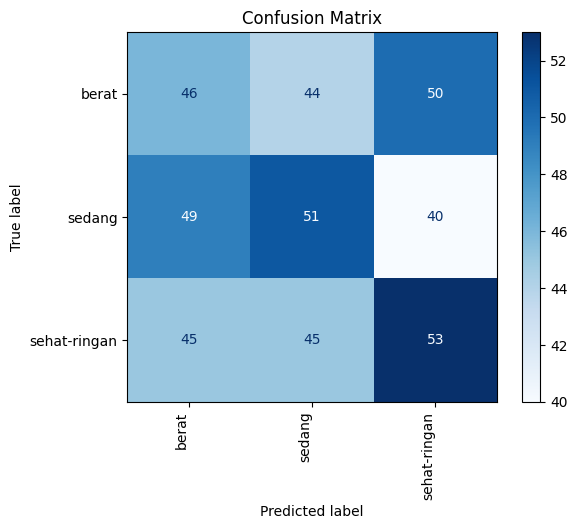

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi probabilitas untuk semua data di train_generator
predictions = model.predict(
    train_generator,
    steps=train_generator.n // BATCH_SIZE + 1,
    verbose=1
)

# Ambil kelas prediksi dengan nilai probabilitas tertinggi
predicted_classes = np.argmax(predictions, axis=1)

# Label asli dari generator
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Hitung confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Tampilkan confusion matrix dengan label kelas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xticks(rotation=90, ha='right')
plt.show()


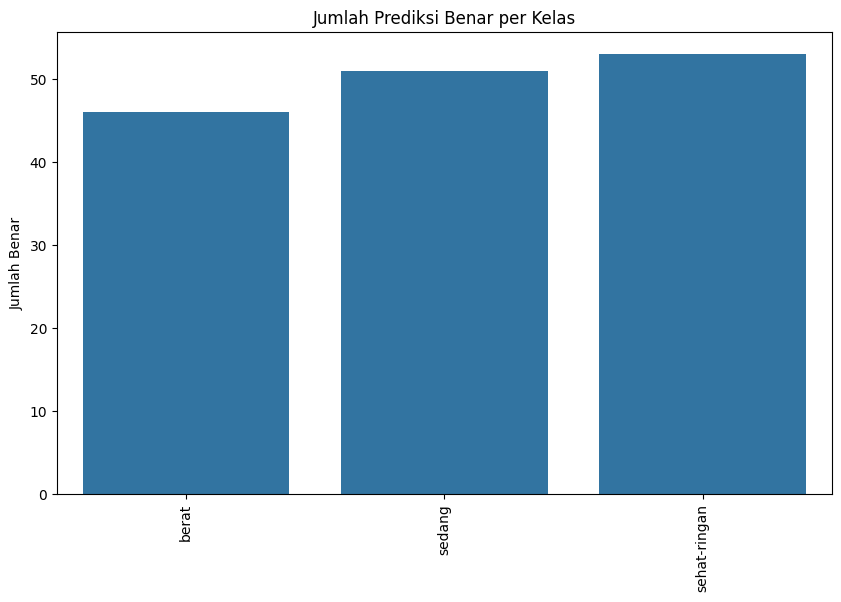

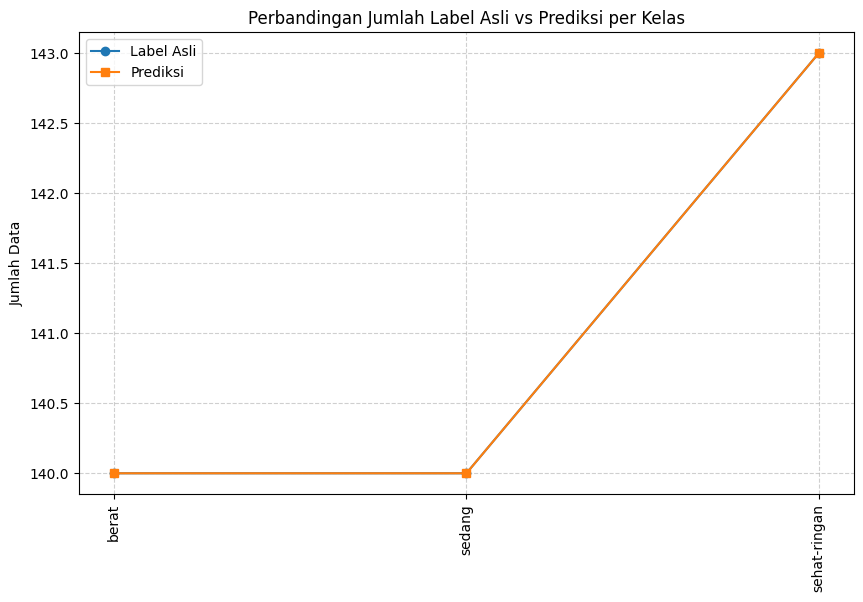

In [13]:
import seaborn as sns

# Hitung jumlah data per kelas (label asli dan prediksi)
true_counts = np.bincount(true_classes, minlength=len(class_labels))
pred_counts = np.bincount(predicted_classes, minlength=len(class_labels))

# === 1. Grafik Batang: Jumlah Prediksi Benar/Salah per Kelas ===
plt.figure(figsize=(10,6))
sns.barplot(x=class_labels, y=np.diag(cm))  # nilai diagonal CM = prediksi benar
plt.title("Jumlah Prediksi Benar per Kelas")
plt.ylabel("Jumlah Benar")
plt.xticks(rotation=90)
plt.show()

# === 2. Grafik Garis: Perbandingan Label Asli vs Prediksi per Kelas ===
plt.figure(figsize=(10,6))
plt.plot(class_labels, true_counts, marker='o', label="Label Asli")
plt.plot(class_labels, pred_counts, marker='s', label="Prediksi")
plt.title("Perbandingan Jumlah Label Asli vs Prediksi per Kelas")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# Plotting Model Accuracy and Loss:

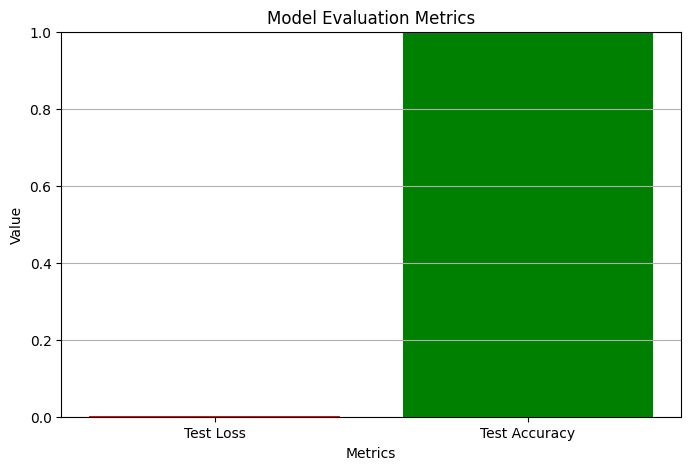

In [15]:
import matplotlib.pyplot as plt

# Misal hasil evaluasi model
metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]  # pastikan test_loss dan test_accuracy sudah di-set dari model.evaluate()

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['red', 'green'])
plt.ylim(0, 1)  # range 0 sampai 1 karena accuracy dan loss biasanya di sini
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.grid(axis='y')
plt.show()



# Visualize Test Loss and Accuracy Using Line Graphs

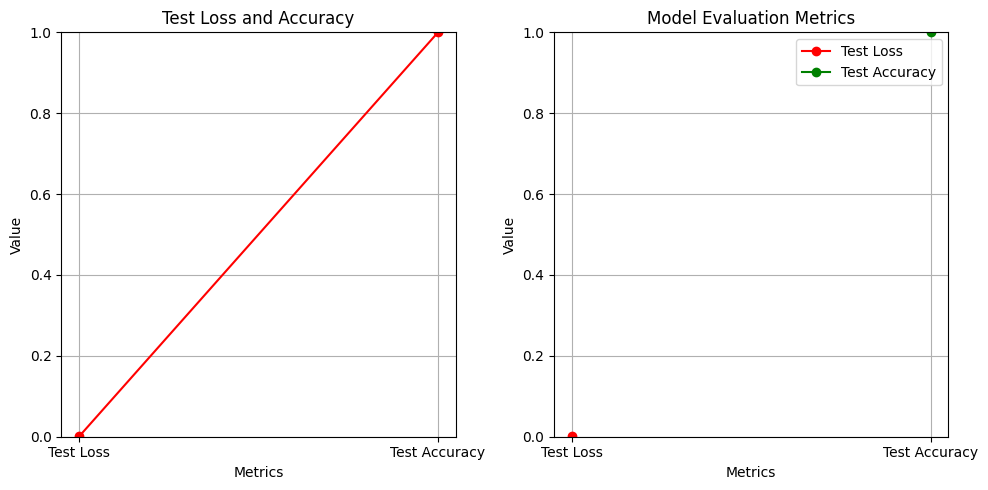

In [16]:
import matplotlib.pyplot as plt

metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

plt.figure(figsize=(10, 5))

# Plot gabungan garis antara loss dan accuracy
plt.subplot(1, 2, 1)
plt.plot(metrics, values, marker='o', color='red')
plt.ylim(0, 1)
plt.title('Test Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.grid(True)

# Plot terpisah untuk loss dan accuracy dengan legend
plt.subplot(1, 2, 2)
plt.plot(['Test Loss'], [test_loss], marker='o', color='red', label='Test Loss')
plt.plot(['Test Accuracy'], [test_accuracy], marker='o', color='green', label='Test Accuracy')
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Model Predictions

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

model = tf.keras.models.load_model('resnet_model.keras')

dataset_path = 'Dataset'  # Pastikan ini path dataset setelah split (train/val)

# Pakai kelas sesuai kondisi awal
class_names = ['berat', 'sedang', 'sehat-ringan']

def prepare_image(image_path):
    """Preprocesses the image for model prediction."""
    img = load_img(image_path, target_size=(224, 224))  # Ukuran sesuai model ResNet50
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(image_path):
    """Predicts the class and confidence of an image."""
    img_array = prepare_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = class_names[predicted_class_idx]
    confidence = np.max(predictions)
    return predicted_class, confidence

# Pilih random satu gambar dari tiap kelas
sample_images = []
for class_dir in class_names:
    class_dir_path = os.path.join(dataset_path, class_dir)
    images_in_class = [f for f in os.listdir(class_dir_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    random_image = random.choice(images_in_class)
    sample_images.append(os.path.join(class_dir_path, random_image))

plt.figure(figsize=(15, 10))
for i, image_path in enumerate(sample_images[:6]):
    actual_class = os.path.basename(os.path.dirname(image_path))
    predicted_class, confidence = predict_image(image_path)

    plt.subplot(2, 3, i + 1)
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2%}")

plt.tight_layout()
plt.savefig("predicted_images_grid.png", format="png", dpi=300)  # Save with high resolution
plt.show()
